# First Look at Abalone Data
This notebook attempts to:
- Read in raw data
- Split-off a final test set of data
- Explore the training/validation data
- Use a basic model to perform predictions

In [1]:
%load_ext lab_black
%load_ext autoreload
%load_ext watermark

In [2]:
%autoreload 2

In [3]:
%watermark -ntz -p pandas -a Simon-Lee-UK -u -d -t -z

Author: Simon-Lee-UK

Last updated: 2021-05-17 18:25:20BST

pandas: 1.2.4



In [4]:
import sys

import altair as alt
import json
from pathlib import Path
import pandas as pd
from pandas_profiling import ProfileReport
import pickle
import pprint
from pyprojroot import here
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

sys.path.append(
    str(here())
)  # adds the project directory to a list of locations the python interpreter searches through when attempting to import modules

raw_data_path = here() / "data" / "raw" / "abalone_raw.csv"
model_dir = here() / "models"
model_params_dir = model_dir / "CV_params"

In [5]:
def snake_case_column_headers(df):
    """Converts all column headers to snakecase."""
    conversion_dict = {
        col_header: col_header.strip().lower().replace(" ", "_")
        for col_header in df.columns
    }
    return df.rename(conversion_dict, axis="columns")

In [6]:
def is_repeat(model_path, live_params):
    """Checks whether current parameter candidates matches those on the saved GridSearchCV object."""
    try:
        saved_gridsearch = pickle.load(open(model_path, "rb"))
        if saved_gridsearch.param_grid == live_params:
            return True
        else:
            return False
    except FileNotFoundError:
        return False

## Read data, convert column headers and one-hot encode sex column
For now, dropped the one-hot encoded column for sex = infant.  
This information is already encoded via a zero in both the `sex_f` and `sex_m` columns.

In [7]:
abalone_all = (
    pd.read_csv(raw_data_path)
    .pipe(pd.get_dummies)
    .pipe(snake_case_column_headers)
    .drop("sex_i", axis="columns")
)

In [8]:
abalone_all.head(3)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_f,sex_m
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9,1,0


## Split data into training, validation (model comparison) and test sets

In [9]:
target_column = "rings"
X = abalone_all[[col for col in abalone_all.columns if col != target_column]]
y = abalone_all[[target_column]]

In [10]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101
)
training_full = pd.concat([X_train_full, y_train_full], axis="columns")

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=202
)

validate_full = pd.concat([X_validate, y_validate], axis="columns").rename(
    columns={"rings": "rings_true"}
)

## Inspect the features of the training/validation set

In [11]:
# report = ProfileReport(training_full, title="Pandas Profiling Overview")
# report

## Train an initial Random Forest model

In [12]:
rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [2, 4, 6, 8, 10, 12],
    "min_samples_split": [2, 4, 6],
}

In [14]:
if is_repeat(model_dir / "random_forest.pickle", rf_params):
    print(
        f"Matches saved param search...\n"
        f"Loading from: {model_dir.relative_to(here())}/random_forest.pickle"
    )
    rf_gridsearch = pickle.load(open(model_dir / "random_forest.pickle", "rb"))
else:
    print(f"New param search...\n" f"Tuning new GridSearchCV object...\n")
    rf = RandomForestRegressor(random_state=42)
    rf_gridsearch = GridSearchCV(rf, rf_params, n_jobs=-1, cv=5, verbose=9).fit(
        X_train, y_train.squeeze()
    )
    print(f"Saving to: {model_dir.relative_to(here())}/random_forest.pickle")
    pickle.dump(
        rf_gridsearch, open(model_dir / "random_forest.pickle", "wb")
    )  # save the new GridSearchCV object

New param search...
Tuning new GridSearchCV object...

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Saving to: models/random_forest.pickle


In [15]:
best_rf = rf_gridsearch.best_estimator_
pprint.pp(rf_gridsearch.best_params_)

{'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 400}


In [16]:
rf_gridsearch.best_score_

0.5403371455248307

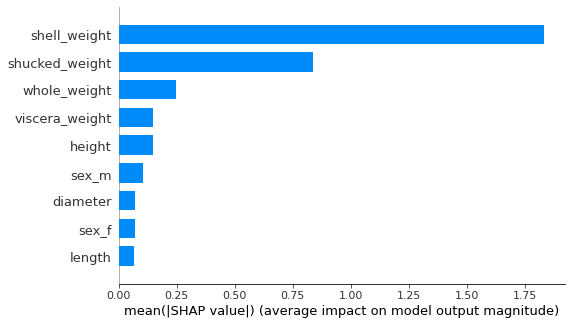

In [17]:
rf_shap_values = shap.TreeExplainer(rf_gridsearch.best_estimator_).shap_values(X_train)
shap.summary_plot(rf_shap_values, X_train, plot_type="bar")

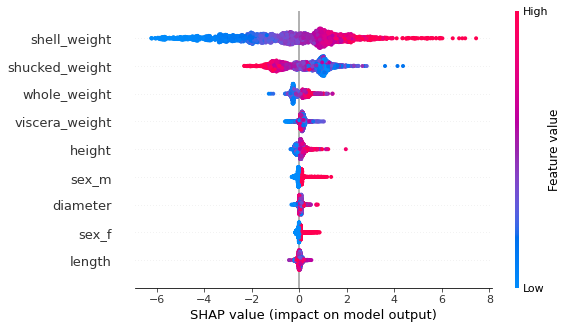

In [18]:
shap.summary_plot(rf_shap_values, X_train)

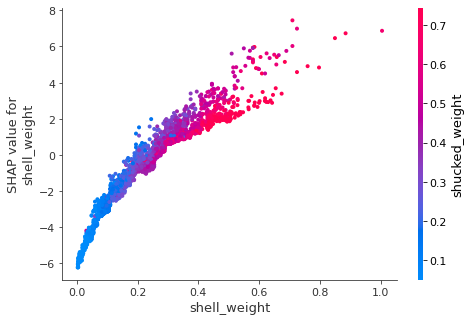

In [19]:
shap.dependence_plot("shell_weight", rf_shap_values, X_train)

Should give the [**SHAP package**](https://shap.readthedocs.io/en/latest/) a try for investigating the feature importance.  
Check first whether it works for regression as well as classification problems.  
  
Sounds like it does... [here](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) is a good article on how it works.  
There are specialised functions for working with XGBoost; above I've started by looking at Random Forest results using the generalised TreeExplainer.

In [20]:
best_rf_validation = validate_full.copy().assign(
    rings_pred=best_rf.predict(X_validate),
    rings_pred_r=lambda df: df["rings_pred"].round().astype("int64"),
    rings_diff=lambda df: df["rings_pred_r"] - df["rings_true"],
    correct=lambda df: df["rings_diff"] == 0,
)
best_rf_validation.sample(5, random_state=5)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_m,rings_true,rings_pred,rings_pred_r,rings_diff,correct
3969,0.380,0.300,0.090,0.2770,0.1655,0.0625,0.0820,0,0,6,6.887574,7,1,False
1058,0.245,0.180,0.065,0.0710,0.0300,0.0130,0.0215,0,0,4,4.525316,5,1,False
3670,0.590,0.465,0.135,0.9895,0.4235,0.1990,0.2800,0,1,8,10.827489,11,3,False
787,0.495,0.385,0.135,0.7090,0.2110,0.1375,0.2620,0,1,12,13.914015,14,2,False
455,0.575,0.470,0.140,0.8375,0.3485,0.1735,0.2400,0,1,11,10.254198,10,-1,False


In [21]:
best_rf.score(X_train, y_train)

0.7555060597898319

In [22]:
best_rf.score(X_validate, y_validate)

0.5651823477802602

In [23]:
alt.Chart(best_rf_validation).mark_circle().encode(
    x="rings_true",
    y="rings_diff",
    color="correct",
).configure_mark(
    opacity=0.3,
)

alt.Chart(...)

In [24]:
alt.Chart(best_rf_validation).mark_circle().encode(
    x="shell_weight",
    y="rings_diff",
    color="correct",
).configure_mark(
    opacity=0.3,
)

alt.Chart(...)